In [140]:
# system information
import os
from glob import glob

# computing
import numpy as np
import pandas as pd
from datetime import datetime
import scipy as sp
import scipy.optimize as op

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
%matplotlib inline

# ROOT files handling
import uproot as ur

In [2]:
# define ticks
def set_ticks(ax, xMaj, yMaj):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.minorticks_on()
    ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=14)
    ax.tick_params(which='minor', width=1.0, length=4, direction='in', labelsize=14)
    ax.yaxis.get_offset_text().set_fontsize(14)
    ax.xaxis.get_offset_text().set_fontsize(14)

def exp(t, a_m, a_p, tau_p, tau_m, b):
    exp_p = a_p * np.exp(-t/tau_p)
    exp_m = a_m * np.exp(-t/tau_m)
    return exp_p + exp_m + b 


In [4]:
# open file
file = ur.open("data/spectrum20220527.root")

# gey handles of the 'root' file
file.keys()

['pjmca;1']

In [5]:
a = 0.02588903364201166 
b = 0.0117937685867166

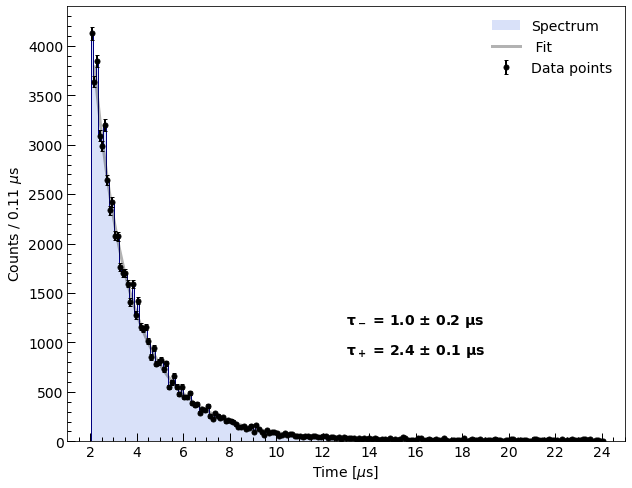

In [34]:
# access the TNtuple
events1 = ur.open("data/spectrum20220527.root:pjmca")
spectrum1 = a + b*events1['ch0'].array()

events2 = ur.open("data/spectrum20220524.root:pjmca")
spectrum2 = a + b*events2['ch0'].array()

total = np.concatenate((spectrum1,spectrum2))
total = total[total > 2.]

# create plot
fig, ax = plt.subplots(figsize=(10,8))

# plot histogram
n, bins, _ = ax.hist(total, bins=200, fc='royalblue', alpha=0.2, label="Spectrum")
n, bins, _ = ax.hist(total, bins=200, histtype='step', ec='navy', lw=1)

# array of bin centers
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

# set Poisson uncertainty on each bin   
poisson_err =  np.sqrt(n)  

# bin width 
binwidth = bins[1] - bins[0]

ax.errorbar(x, n, yerr=poisson_err, label='Data points', marker = 'o',markerfacecolor = 'black',
                                markeredgecolor = 'black',markersize=5, lw = 0, ecolor='black', elinewidth=2, capsize=2)

# perform fit 
par, cov = op.curve_fit(f = exp, xdata = x[1:], ydata = n[1:], sigma = poisson_err[1:],
                      bounds=((2000, 30, 1.9, 0.7, 0.), (15000, 9000, 2.4, 1.,3.)) )
# get parameters
a_m, a_p, tau_p, tau_m, baseline = par
_, _, err_p, err_m,_  = np.sqrt(np.diag(cov))

# create array to plot fit results 
x_g = np.arange(x[1],20,0.02)

# plot curve and data points
ax.plot(x_g, exp(x_g, *par), color = 'black', ls='-', alpha=0.3, lw=3, label = ' Fit')

# labels
ax.set_xlabel("Time [$\mu$s]", fontsize=14)
ax.set_ylabel("Counts / %1.2f $\mu$s" %binwidth, fontsize=14)

# ticks
set_ticks(ax, 2, 500)

# limits 
ax.set_xlim(1,25)

# legend
ax.legend(loc="upper right", frameon=False, fontsize=14)

ax.text(0.5,0.27, '$\\mathbf{\\tau_-}$ = %1.1f $\\mathbf{\\pm}$ %1.1f $\\mathbf{\\mu}$s ' % (tau_m,err_m), 
        fontweight = 'bold',fontsize = 14,  transform=ax.transAxes)
ax.text(0.5,0.2, '$\\mathbf{\\tau_+}$ = %1.1f $\\mathbf{\\pm}$ %1.1f $\\mathbf{\\mu}$s ' % (tau_p,err_p), 
        fontweight = 'bold',fontsize = 14,  transform=ax.transAxes)


# show and save
#fig.savefig('spectrum_fit.pdf', dpi = 200)
plt.show()

## Second approach

In [54]:
def exponential(x, a, tau):
    return a * np.exp(- x / tau)

In [153]:
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams["font.family"] = "serif"
plt.rcdefaults()

[6.44821665e+03 2.16231002e+00]


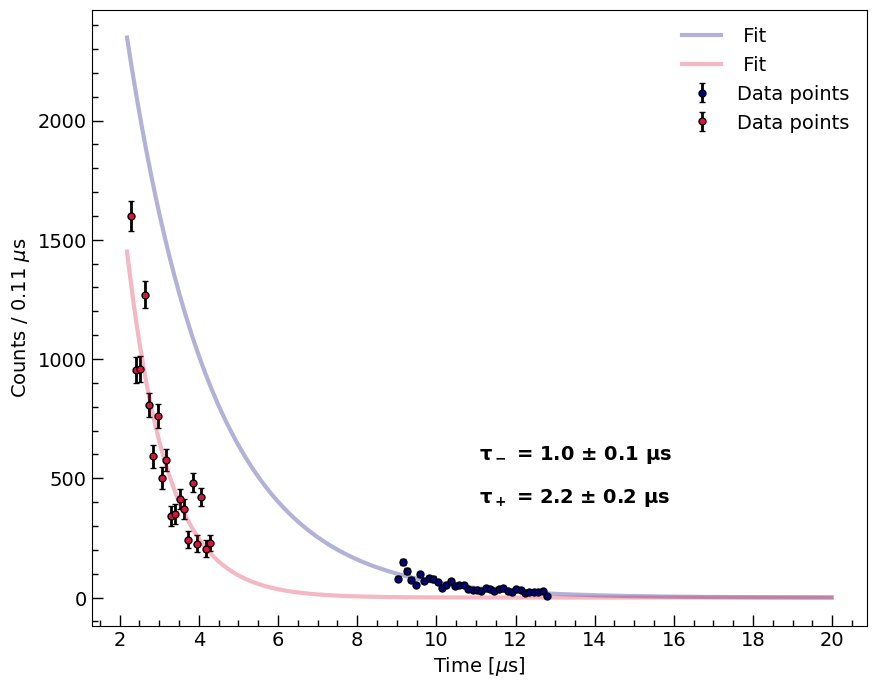

1.8947634704745477


In [157]:
# create plot
fig, ax = plt.subplots(figsize=(10,8))

# extract the baseline from 7 * tau_2
indeces = np.where(x > 15.)
i = indeces[0][0]
baseline = np.mean(n[int(i):])

# select between 7 us and 11 us
indeces = np.where(x > 9.)
i_in = indeces[0][0]
indeces = np.where(x < 13.)
i_fin = indeces[0][-1]

# subtract the baseline
n_p = n[i_in:i_fin] - baseline

# compute fit
par, cov = op.curve_fit(f = exponential, xdata = x[i_in:i_fin], ydata = n_p, sigma = poisson_err[i_in:i_fin])

print(par)
# plot
ax.errorbar(x[i_in:i_fin], n_p, yerr=poisson_err[i_in:i_fin], label='Data points', marker = 'o',markerfacecolor = 'navy',
                                markeredgecolor = 'black',markersize=5, lw = 0, ecolor='black', elinewidth=2, capsize=2)
x_g = np.arange(x[1],20,0.02)
ax.plot(x_g, exponential(x_g, *par), color = 'navy', ls='-', alpha=0.3, lw=3, label = ' Fit')

# get parameters
a_p, tau_p = par
s_a_p, s_tau_p  = np.sqrt(np.diag(cov))

# fit between 3 us and 6 us
indeces = np.where(x > 2.25)
i_in = indeces[0][0]
indeces = np.where(x < 4.5)
i_fin = indeces[0][-1]

# subtract the baseline
# n_n = n[i_in:i_fin] - baseline - exponential(9., *par) * np.exp((x[i_in:i_fin] - 9.)/tau_p)
n_n = n[i_in:i_fin] - baseline - exponential(x[i_in:i_fin], *par)

# compute fit
par, cov = op.curve_fit(f = exponential, xdata = x[i_in:i_fin], ydata = n_n, sigma = poisson_err[i_in:i_fin], bounds =((1e2,0.5),(1e5,1.5)))

# plot
ax.errorbar(x[i_in:i_fin], n_n, yerr=poisson_err[i_in:i_fin], label='Data points', marker = 'o',markerfacecolor = 'crimson',
                                markeredgecolor = 'black',markersize=5, lw = 0, ecolor='black', elinewidth=2, capsize=2)
x_g = np.arange(x[1],20,0.02)
ax.plot(x_g, exponential(x_g, *par), color = 'crimson', ls='-', alpha=0.3, lw=3, label = ' Fit')

# get parameters
a_n, tau_n = par
s_a_n, s_tau_n  = np.sqrt(np.diag(cov))

# print
ax.text(0.5,0.27, '$\\mathbf{\\tau_-}$ = %1.1f $\\mathbf{\\pm}$ %1.1f $\\mathbf{\\mu}$s ' % (tau_n, s_tau_n), 
        fontweight = 'bold',fontsize = 14,  transform=ax.transAxes)
ax.text(0.5,0.2, '$\\mathbf{\\tau_+}$ = %1.1f $\\mathbf{\\pm}$ %1.1f $\\mathbf{\\mu}$s ' % (tau_p, s_tau_p), 
        fontweight = 'bold',fontsize = 14,  transform=ax.transAxes)

# labels
ax.set_xlabel("Time [$\mu$s]", fontsize=14)
ax.set_ylabel("Counts / %1.2f $\mu$s" %binwidth, fontsize=14)

# ticks
set_ticks(ax, 2, 500)

# legend
ax.legend(loc="upper right", frameon=False, fontsize=14)

plt.show()

print(a_n/a_p)
